# AAE with no pretraining: Performance evaluation

Jacqueline R. M. A. Maasch | May 2022

## Preamble

In [147]:
# Importations.
import moses
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance
from moses.metrics import weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses import get_dataset
from collections import OrderedDict
from tdc.chem_utils import MolFilter
import warnings
from tdc import Oracle
from rdkit import Chem                                                                                                                                                                   
from rdkit import RDLogger 
from random import sample
import tdc
from tdc import Evaluator
from tdc.single_pred import HTS
from importlib.metadata import version

In [148]:
# View versioning.
print("\npython version:", sys.version)
print("\n--- LIBRARY VERSIONS ---")
print("tdc:         ", version("PyTDC"))
print("numpy:       ", version("numpy"))
print("pandas:      ", version("pandas"))
print("moses:       ", version("molsets"))
print("rdkit:       ", version("rdkit-pypi"))
print("scipy:       ", version("scipy"))
print("seaborn:     ", version("seaborn"))
print("matplotlib:  ", version("matplotlib"))


python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

--- LIBRARY VERSIONS ---
tdc:          0.3.6
numpy:        1.22.3
pandas:       1.2.4
moses:        0.3.1
rdkit:        2021.9.5.1
scipy:        1.7.2
seaborn:      0.11.1
matplotlib:   3.3.4


In [149]:
%%capture
# Installs.
#!python3.8 -m pip install fcd_torch
#!python3.8 -m pip install rxn4chemistry

## Define functions

In [150]:
def compute_tdc_metrics(generated, training):
    
    metrics_dict = dict()
    
    kl = Evaluator(name = "KL_Divergence")
    metrics_dict["KL divergence"] = kl(generated, training)

    uniqueness = Evaluator(name = "Uniqueness")
    metrics_dict["Uniqueness"] = uniqueness(generated)

    validity = Evaluator(name = "Validity")
    metrics_dict["Validity"] = validity(generated)

    novelty = Evaluator(name = "Novelty")
    metrics_dict["Novelty"] = novelty(generated, training)

    #fcd = Evaluator(name = "FCD_Distance")
    #metrics_dict["FCD distance"] = fcd(generated, training)

    diversity = Evaluator(name = "Diversity")
    metrics_dict["Diversity"] = diversity(generated)

    return metrics_dict


def remove_ungrammatical(generated):
    # Disable warnings.
    RDLogger.DisableLog("rdApp.*")  
    
    # Filter molecules.
    keep = []
    invalid_string = 0
    invalid_chemistry = 0
    for molecule in generated:
        m = Chem.MolFromSmiles(molecule, sanitize = False)
        if m is None:
            invalid_string += 1
        else:
            try:
                Chem.SanitizeMol(m)
                keep.append(molecule)
            except:
                invalid_chemistry += 1
                
    print("Total strings with invalid SMILES syntax:", invalid_string)
    print("Total strings with invalid chemistry:", invalid_chemistry)
    print("Total valid SMILES strings:", len(keep))
    print("Percent valid SMILES strings:", (len(keep) / len(generated)))
    
    return keep


def plot_distribution_basic(df, 
                            log_x = None, 
                            log_y = None, 
                            save_path = "./plt.pdf", 
                            save = False):
    
    sns.displot(data = df, 
                x = "Value", 
                hue = "Distribution", 
                col = "Metric",
                kind = "kde", 
                log_scale = (log_x, log_y),
                common_norm = True,
                fill = True,
                height = 5)
    if save:
        plt.savefig(save_path)
    else:
        plt.show()
    
    
def plot_distribution(df, 
                      log_x = None, 
                      log_y = None, 
                      save_path = "./plt.pdf", 
                      save = False):
    
    g = sns.FacetGrid(df.reset_index(), 
                      col = "Metric",
                      hue = "Distribution", 
                      sharex = False, 
                      sharey = False)
    g.map_dataframe(sns.kdeplot, 
                    "Value",
                    fill = True, 
                    log_scale = (log_x, log_y),
                    common_norm = True).add_legend()
    if save:
        plt.savefig(save_path)
    else:
        plt.show()

## Read data

### Generated molecules

In [151]:
# Read in generated molecules.
df_active = pd.read_csv("../aae/generated_molecules_100k/gen_active_finetune_500k.csv")
df_inactive = pd.read_csv("../aae/generated_molecules_100k/gen_inactive_finetune_500k.csv")

print(df_active.info())
display(df_active.head())

print(df_inactive.info())
display(df_inactive.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,CCOc1cc2c(cc1CNCCN1CCCCC1=O)=CC[C<unk><unk>]23...
1,Cc1cc(C(=O)CNc2ccc(OC(C)C)cc2)c2ccc(C)Oc2s1<pa...
2,CC(=O)Nc1ccc(Oc2ncccn2)cc1<pad><pad><pad><pad>...
3,Cc1nc2ccc(Nc3cnccn3)cc2[nH]1<pad><pad><pad><pa...
4,CC(O)CC(=O)O)(c1ccc(OC(C)(C)C)cc1)C(=O)N<pad><...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   SMILES  100000 non-null  object
dtypes: object(1)
memory usage: 781.4+ KB
None


,SMILES
0,CC(=O)OCC(=O)Nc1ccc(C(=O)O)c(C)c1O<unk>O-<pad>...
1,CC(C)(C)c1ccccc1OCCNC(=O)c1ccc(N)cc1r<pad><pad...
2,CC(CC[C<unk><unk>]1NCCNC1=O<pad><pad><pad><pad...
3,Cn1cc(Br)cc1C(=O)Nc1ccncc1<pad><pad><pad><pad>...
4,CC(C(=O)O)c1ccc2c(c1)Cc1cccc(Cl)c1<pad><pad><p...


### Training data from TDC

In [152]:
df_active_train = pd.read_csv("../sars_data/actives_train.csv")
df_inactive_train = pd.read_csv("../sars_data/inactives_train.csv")

print(df_active_train.info())
display(df_active_train.head())
print(df_inactive_train.info())
display(df_inactive_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  132 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB
None


,SMILES
0,NC(=O)c1ccc(NC(=O)[C@@H]2CCCO2)cc1
1,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O.Cl
2,COC(=O)Nc1sc(C)nc1-c1ccccc1
3,OC1CCN(Cc2ccsc2)CC1
4,CC(C(O)c1ccc(O)cc1)N1CCC(Cc2ccccc2)CC1.CC(C(O)...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  1758 non-null   object
dtypes: object(1)
memory usage: 13.9+ KB
None


,SMILES
0,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@H]2O)c(=O)n1
1,COc1cc(Br)c(C[N+]2(CCOCCC3CCC4CC3C4(C)C)CCOCC2...
2,O=C1CCc2ccc(OCCCCN3CCN(c4cccc(Cl)c4Cl)CC3)cc2N1
3,COCC1=C(C(=O)OC(C)OC(=O)OC(C)C)N2C(=O)[C@@H](N...
4,c1nc(N2CCC2)c2[nH]cnc2n1


### Validation data

In [153]:
df_active_val = pd.read_csv("../sars_data/actives_val.csv")
df_inactive_val = pd.read_csv("../sars_data/inactives_val.csv")

print(df_active_val.info())
display(df_active_val.head())
print(df_inactive_val.info())
display(df_inactive_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  34 non-null     object
dtypes: object(1)
memory usage: 400.0+ bytes
None


,SMILES
0,O=C(CCl)N1CCN(Cc2cccc3ccccc23)CC1
1,O=C(CCl)N1CCN(S(=O)(=O)c2cccs2)CC1
2,C[C@H]1CN(c2c(F)c(N)c3c(=O)c(C(=O)O)cn(C4CC4)c...
3,C/C=C/c1ccc(OC)cc1
4,Clc1cccc(CN2CCOCC2)c1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   SMILES  440 non-null    object
dtypes: object(1)
memory usage: 3.6+ KB
None


,SMILES
0,CCC1(C)CC(=O)NC1=O
1,CC(=O)N[C@@H](CCC(N)=O)C(=O)O
2,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O
3,CC(C)n1cnc(S(N)(=O)=O)c1
4,Cc1ccc(=O)n(-c2ccccc2)c1


## Process data

In [154]:
# Remove padding.
remove_pad = lambda x: x.replace("<pad>", "")
df_active.SMILES = df_active.SMILES.map(remove_pad)
df_inactive.SMILES = df_inactive.SMILES.map(remove_pad)

In [155]:
# Listify.
actives_gen = list(df_active.SMILES)
inactives_gen = list(df_inactive.SMILES)

actives_train = list(df_active_train.SMILES)
inactives_train = list(df_inactive_train.SMILES)

actives_val = list(df_active_val.SMILES)
inactives_val = list(df_inactive_val.SMILES)

In [156]:
# Filter out molecules that do not pass RDKit checks.
# Some metrics will require this step.
print("--- de novo actives ---")
actives_gen_grammatical = remove_ungrammatical(actives_gen)
print("\n--- de novo inactives ---")
inactives_gen_grammatical = remove_ungrammatical(inactives_gen)
print("\n--- training actives ---")
actives_train_grammatical = remove_ungrammatical(actives_train)
print("\n--- training inactives ---")
inactives_train_grammatical = remove_ungrammatical(inactives_train)
print("\n--- validation actives ---")
actives_val_grammatical = remove_ungrammatical(actives_val)
print("\n--- validation inactives ---")
inactives_val_grammatical = remove_ungrammatical(inactives_val)

--- de novo actives ---
Total strings with invalid SMILES syntax: 36387
Total strings with invalid chemistry: 6574
Total valid SMILES strings: 57039
Percent valid SMILES strings: 0.57039

--- de novo inactives ---
Total strings with invalid SMILES syntax: 56526
Total strings with invalid chemistry: 5200
Total valid SMILES strings: 38274
Percent valid SMILES strings: 0.38274

--- training actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 132
Percent valid SMILES strings: 1.0

--- training inactives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 1758
Percent valid SMILES strings: 1.0

--- validation actives ---
Total strings with invalid SMILES syntax: 0
Total strings with invalid chemistry: 0
Total valid SMILES strings: 34
Percent valid SMILES strings: 1.0

--- validation inactives ---
Total strings with invalid SMILES syntax: 0
Total strings wit

## Global-level metrics

### MOSES metrics

In [157]:
moses.get_all_metrics?

Signature:
moses.get_all_metrics(
    gen,
    k=None,
    n_jobs=1,
    device='cpu',
    batch_size=512,
    pool=None,
    test=None,
    test_scaffolds=None,
    ptest=None,
    ptest_scaffolds=None,
    train=None,
)
Docstring:
Computes all available metrics between test (scaffold test)
and generated sets of SMILES.
Parameters:
    gen: list of generated SMILES
    k: int or list with values for unique@k. Will calculate number of
        unique molecules in the first k molecules. Default [1000, 10000]
    n_jobs: number of workers for parallel processing
    device: 'cpu' or 'cuda:n', where n is GPU device number
    batch_size: batch size for FCD metric
    pool: optional multiprocessing pool to use for parallelization

    test (None or list): test SMILES. If None, will load
        a default test set
    test_scaffolds (None or list): scaffold test SMILES. If None, will
        load a default scaffold test set
    ptest (None or dict): precalculated statistics of the test set. 

In [158]:
# Compute MOSES metrics for de novo actives.
start_time = time.time()
metrics_active = moses.get_all_metrics(gen = actives_gen, train = actives_train, test = actives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_active)

Complete in 2692.8389163017273 seconds.


{'valid': 0.57035,
 'unique@1000': 0.918,
 'unique@10000': 0.8348,
 'FCD/Test': 31.088566588019077,
 'SNN/Test': 0.2549952479832621,
 'Frag/Test': 0.7526036712189199,
 'Scaf/Test': 0.17281190840031235,
 'FCD/TestSF': 6.8052287385621355,
 'SNN/TestSF': 0.5123404942224955,
 'Frag/TestSF': 0.936318086300711,
 'Scaf/TestSF': 0.1686708544350881,
 'IntDiv': 0.8579749414584863,
 'IntDiv2': 0.8486996495004041,
 'Filters': 0.8572981502586131,
 'logP': 0.5077143845884111,
 'SA': 0.4828413997352261,
 'QED': 0.14782494953051836,
 'weight': 81.46301962829844,
 'Novelty': 0.9982490136110008}

In [159]:
# Compute MOSES metrics for de novo inactives.
start_time = time.time()
metrics_inactive = moses.get_all_metrics(gen = inactives_gen, train = inactives_train, test = inactives_val)
print("Complete in {} seconds.".format(time.time() - start_time))

display(metrics_inactive)

Complete in 1814.9796772003174 seconds.


{'valid': 0.38269,
 'unique@1000': 0.99,
 'unique@10000': 0.9495,
 'FCD/Test': 7.509553184601771,
 'SNN/Test': 0.3190321791424034,
 'Frag/Test': 0.9253816810456894,
 'Scaf/Test': 0.2506608101294656,
 'FCD/TestSF': 6.280719756659892,
 'SNN/TestSF': 0.4711592943304677,
 'Frag/TestSF': 0.9492970567111175,
 'Scaf/TestSF': 0.12061943671024167,
 'IntDiv': 0.8796104740584066,
 'IntDiv2': 0.8702351148044922,
 'Filters': 0.9392981264208629,
 'logP': 0.6177365355640336,
 'SA': 0.47119061658882183,
 'QED': 0.11803667558693955,
 'weight': 65.4114625460556,
 'Novelty': 0.9928737638161722}

### TDC metrics

In [160]:
# NOTE: must subsample generative inactives to < 10k to get TDC functions to work.
# This is due to a glitch in TDC.
actives_gen_grammatical_10k = sample(actives_gen_grammatical, 10000)
inactives_gen_grammatical_10k = sample(inactives_gen_grammatical, 10000)

In [161]:
%%capture
# Throws error.
'''
ompute all metrics for active de novos vs their training data.
compute_tdc_metrics(actives_gen_grammatical, actives_train_grammatical)
'''

In [162]:
# KL divergence of active generated data and active training data.
kl = Evaluator(name = "KL_Divergence")
kl(actives_gen_grammatical_10k, actives_train_grammatical)

0.5087838138194272

In [163]:
%%capture
# Throws error.
'''
# Compute all metrics for inactive de novos vs their training data.
compute_tdc_metrics(inactives_gen_grammatical_10k, inactives_train_grammatical)
'''

In [164]:
# KL divergence of inactive generated data and inactive training data.
kl(inactives_gen_grammatical_10k, inactives_train_grammatical)

RDKit ERROR: [23:56:27] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:56:27] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [23:56:47] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:56:47] Explicit valence for atom # 2 N, 4, is greater than permitted


0.6555972219482584

In [165]:
# KL divergence of active training data and inactive training data.
kl(actives_train_grammatical, inactives_train_grammatical)

0.854377160131264

In [166]:
# KL divergence of active de novos and inactive training data.
kl(actives_gen_grammatical_10k, inactives_train_grammatical)

0.5401632922907622

In [167]:
# KL divergence of inactive de novos and active training data.
kl(inactives_gen_grammatical_10k, actives_train_grammatical)

RDKit ERROR: [23:58:38] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:58:38] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [23:58:52] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:58:52] Explicit valence for atom # 2 N, 4, is greater than permitted


0.6147609272531042

In [168]:
# KL divergence of active de novos and inactive de novos.
kl(actives_gen_grammatical_10k, inactives_gen_grammatical_10k)

RDKit ERROR: [23:59:59] Explicit valence for atom # 2 N, 4, is greater than permitted
[23:59:59] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [00:00:14] Explicit valence for atom # 2 N, 4, is greater than permitted
[00:00:14] Explicit valence for atom # 2 N, 4, is greater than permitted


0.9233380320441713

## Molecule-level metrics

### Synthetic accessibility

>Description: Synthetic Accessibility Score stands for how hard or how easy it is to synthesize a given molecule, based on a combination of the molecule’s fragments contributions. The oracle is caluated via RDKit, using a set of chemical rules defined by Ertl et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility]

In [169]:
# Synthetic accessibility.
sa = Oracle(name = "SA")

'''
sa_actives_gen = sa(actives_gen_grammatical)
sa_inactives_gen = sa(inactives_gen_grammatical)
sa_actives_train = sa(actives_train_grammatical)
sa_inactives_train = sa(inactives_train_grammatical)
'''

invalid = 0
sa_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_gen))

invalid = 0
sa_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_gen.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_gen))

invalid = 0
sa_actives_train = []
for molecule in actives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_actives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_actives_train))

invalid = 0
sa_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        sa_one = sa(molecule)
        sa_inactives_train.append(sa_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(sa_inactives_train))

print()
sa_dict = {"Generated actives": sa_actives_gen,
           "Generated inactives": sa_inactives_gen,
           "Training actives": sa_actives_train,
           "Training inactives": sa_inactives_train}

for key,value in sa_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 57039

Total invalid: 0
Total valid: 38274

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[1.8431290622173222, 2.297461043379018, 3.643866309691986, 2.3593300256779433, 1.5344813385124567, 2.0411155037212936, 2.561010102644163, 1.9123653710952997, 2.446177220138429, 2.233812922333213, 1.64316112734938, 2.102408663804237, 1.8022848409604144, 2.666426818409871, 1.7624579420731372, 1.8216967756923506, 1.7426848409604148, 2.598465103246115, 3.0473878818769577, 3.9410279169398628] 

Generated inactives :
[2.1160684753483316, 1.64096078304064, 2.5100415895701342, 2.4223160915676534, 2.507471836929083, 1.9089790121746546, 2.4710163875303763, 1.1592175456870955, 1.9614933323728607, 3.4958796512617365, 3.714855279952829, 1.9750374209357044, 1.8831620214945435, 1.8832930907329484, 2.6734174802605484, 1.693883643309814, 3.5633329603533914, 2.4103295029650766, 1.9400223215021768, 1.9320415599635758] 

Training actives :
[2

### QED

> Description: QED stands for Quantitative Estimate of Drug-likeness. The oracle is caluated via RDKit, using a set of chemical rules about drug-likeliness defined by Bickerton et al. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [170]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
inactives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in inactives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            inactives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo inactives with invalid valence:", invalid_valence)
print("Total de novo inactives with valid valence:", len(inactives_gen_grammatical_keep))

RDKit ERROR: [00:08:01] Explicit valence for atom # 7 N, 4, is greater than permitted
[00:08:01] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [00:08:03] Explicit valence for atom # 4 O, 3, is greater than permitted
[00:08:03] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [00:08:05] Explicit valence for atom # 18 N, 4, is greater than permitted
[00:08:05] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [00:08:06] Explicit valence for atom # 6 C, 5, is greater than permitted
[00:08:06] Explicit valence for atom # 6 C, 5, is greater than permitted
RDKit ERROR: [00:08:07] Explicit valence for atom # 15 N, 4, is greater than permitted
[00:08:07] Explicit valence for atom # 15 N, 4, is greater than permitted


Total de novo inactives with invalid valence: 5
Total de novo inactives with valid valence: 38269


In [171]:
# Address this error:
# RDKit ERROR: Explicit valence for atom # 14 C, 5, is greater than permitted.
actives_gen_grammatical_keep = []
invalid_valence = 0
for molecule in actives_gen_grammatical:
        m = Chem.MolFromSmiles(molecule, sanitize = True)
        try:
            m = Chem.RemoveHs(m)
            actives_gen_grammatical_keep.append(molecule)
        except:
            invalid_valence += 1
print("Total de novo actives with invalid valence:", invalid_valence)
print("Total de novo actives with valid valence:", len(actives_gen_grammatical_keep))

RDKit ERROR: [00:08:13] Explicit valence for atom # 10 C, 5, is greater than permitted
[00:08:13] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [00:08:16] Explicit valence for atom # 10 C, 5, is greater than permitted
[00:08:16] Explicit valence for atom # 10 C, 5, is greater than permitted
RDKit ERROR: [00:08:17] Explicit valence for atom # 11 C, 5, is greater than permitted
[00:08:17] Explicit valence for atom # 11 C, 5, is greater than permitted
RDKit ERROR: [00:08:21] Explicit valence for atom # 7 C, 5, is greater than permitted
[00:08:21] Explicit valence for atom # 7 C, 5, is greater than permitted


Total de novo actives with invalid valence: 4
Total de novo actives with valid valence: 57035


In [172]:
# Quantitative Estimate of Drug-likeness.
qed = Oracle(name = "QED")
qed_actives_gen = qed(actives_gen_grammatical_keep) # Use only instances with proper valence.
qed_inactives_gen = qed(inactives_gen_grammatical_keep) # Use only instances with proper valence.
qed_actives_train = qed(actives_train_grammatical)
qed_inactives_train = qed(inactives_train_grammatical)

qed_dict = {"Generated actives": qed_actives_gen,
            "Generated inactives": qed_inactives_gen,
            "Training actives": qed_actives_train,
            "Training inactives": qed_inactives_train}

for key,value in qed_dict.items():
    print(key, ":")
    print(value[:20], "\n")

Generated actives :
[0.8760355461269528, 0.7024269654793898, 0.59712120908929, 0.7594007473063428, 0.7909129723108638, 0.86407675850138, 0.6097629684578506, 0.8993298314640411, 0.32178833676557145, 0.8561787311091357, 0.8041394185697309, 0.7358073447225532, 0.856092582139026, 0.7834615859605757, 0.770885069405048, 0.862512265062736, 0.8622763341063916, 0.8743696127246827, 0.8301926272635483, 0.8967255056116168] 

Generated inactives :
[0.917976998329474, 0.7603013036782852, 0.5668189166571438, 0.8558371405635447, 0.7570297287869758, 0.8453325112114388, 0.6296272887210965, 0.5859367170668043, 0.5217210630658454, 0.6837160113607548, 0.45511768070424236, 0.857801978318871, 0.45393847724764275, 0.7835582041913297, 0.6930591526436826, 0.8626916976807242, 0.5028621912634269, 0.8059942517731652, 0.7261981744952418, 0.5833176069606731] 

Training actives :
[0.814913995911437, 0.7209997551181787, 0.8867424621741485, 0.7798427952514674, 0.08557107474966161, 0.7958887434961184, 0.6113669325066001

### Octanol-water Partition Coefficient (LogP)

>Description: The penalized logP score measures the solubility and synthetic accessibility of a compound. The oracle is caluated via RDKit. (https://tdcommons.ai/functions/oracles/#ibm-rxn-synthetic-accessibility)[https://tdcommons.ai/functions/oracles/]

In [173]:
# LogP.
logp = Oracle(name = "LogP")

'''
logp_actives_gen = logp(actives_gen_grammatical)
logp_inactives_gen = logp(inactives_gen_grammatical)
logp_actives_train = logp(actives_train_grammatical)
logp_inactives_train = logp(inactives_train_grammatical)
'''

invalid = 0
logp_actives_gen = []
for molecule in actives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_gen))

invalid = 0
logp_inactives_gen = []
for molecule in inactives_gen_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_gen.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_gen))

invalid = 0
logp_actives_train = []
for molecule in actives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_actives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_actives_train))

invalid = 0
logp_inactives_train = []
for molecule in inactives_train_grammatical:
    try:
        logp_one = logp(molecule)
        logp_inactives_train.append(logp_one)
    except:
        invalid += 1
print("\nTotal invalid:", invalid)
print("Total valid:", len(logp_inactives_train))

print()
logp_dict = {"Generated actives": logp_actives_gen,
             "Generated inactives": logp_inactives_gen,
             "Training actives": logp_actives_train,
             "Training inactives": logp_inactives_train}

for key,value in logp_dict.items():
    print(key, ":")
    print(value[:20], "\n")


Total invalid: 0
Total valid: 57039

Total invalid: 0
Total valid: 38274

Total invalid: 0
Total valid: 132

Total invalid: 0
Total valid: 1758

Generated actives :
[1.4606161655810947, 1.039375649860672, -0.41407335586828786, 0.20122195847572355, 2.29259095026073, 1.3704723056014463, 1.1480429456294092, 1.4870244142934894, 0.4516347253319436, 1.3769184241690953, 0.9479185478234402, 1.352656660004723, 1.1044797386886211, 0.9504716471002397, 1.0630345970481212, 2.1336722250897657, 1.4941125308814822, 0.4068907676283808, -0.24798715340950217, -3.8715232620362783] 

Generated inactives :
[1.2778996273485936, 0.693977638769689, -0.11352191407010259, 1.762523869491552, 1.2621236755246064, 1.729443252173096, -0.6187391015046918, 1.2759135693280514, 1.8254000895393372, -0.40720197258464874, -1.732713676620121, 0.4025652704909306, 1.7494010377019265, 0.6635758624146636, 1.2956170354992849, 1.8050444346281738, 1.5223797758908497, 0.345917243865976, -0.17265044307567345, 1.4479964005368375] 

T

### Dictionary to dataframe

In [174]:
# SA.
df_sa = pd.DataFrame()
for key,value in sa_dict.items():
    df_sa = pd.concat([df_sa, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_sa["Metric"] = "SA"
display(df_sa)

,Distribution,Value,Metric
0,Generated actives,1.843129,SA
1,Generated actives,2.297461,SA
2,Generated actives,3.643866,SA
3,Generated actives,2.359330,SA
4,Generated actives,1.534481,SA
...,...,...,...
1753,Training inactives,1.919343,SA
1754,Training inactives,2.494935,SA
1755,Training inactives,4.908138,SA
1756,Training inactives,2.417861,SA


In [175]:
# QED.
df_qed = pd.DataFrame()
for key,value in qed_dict.items():
    df_qed = pd.concat([df_qed, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_qed["Metric"] = "QED"
display(df_qed)

,Distribution,Value,Metric
0,Generated actives,0.876036,QED
1,Generated actives,0.702427,QED
2,Generated actives,0.597121,QED
3,Generated actives,0.759401,QED
4,Generated actives,0.790913,QED
...,...,...,...
1753,Training inactives,0.736693,QED
1754,Training inactives,0.877740,QED
1755,Training inactives,0.675608,QED
1756,Training inactives,0.834182,QED


In [176]:
# LogP.
df_logp = pd.DataFrame()
for key,value in logp_dict.items():
    df_logp = pd.concat([df_logp, pd.DataFrame({"Distribution": [key] * len(value), "Value": value})])
df_logp["Metric"] = "LogP"
display(df_logp)

,Distribution,Value,Metric
0,Generated actives,1.460616,LogP
1,Generated actives,1.039376,LogP
2,Generated actives,-0.414073,LogP
3,Generated actives,0.201222,LogP
4,Generated actives,2.292591,LogP
...,...,...,...
1753,Training inactives,1.354121,LogP
1754,Training inactives,1.682860,LogP
1755,Training inactives,-1.982381,LogP
1756,Training inactives,0.699492,LogP


In [177]:
# Aggregate all results.
df_metrics = pd.concat([df_sa, df_qed, df_logp]).reset_index(drop = True)
print(df_metrics.info())
display(df_metrics)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291600 entries, 0 to 291599
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Distribution  291600 non-null  object 
 1   Value         291600 non-null  float64
 2   Metric        291600 non-null  object 
dtypes: float64(1), object(2)
memory usage: 6.7+ MB
None


,Distribution,Value,Metric
0,Generated actives,1.843129,SA
1,Generated actives,2.297461,SA
2,Generated actives,3.643866,SA
3,Generated actives,2.359330,SA
4,Generated actives,1.534481,SA
...,...,...,...
291595,Training inactives,1.354121,LogP
291596,Training inactives,1.682860,LogP
291597,Training inactives,-1.982381,LogP
291598,Training inactives,0.699492,LogP


## Plot distributions

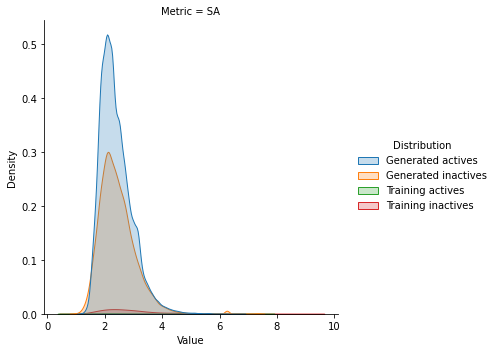

In [178]:
plot_distribution_basic(df_sa)

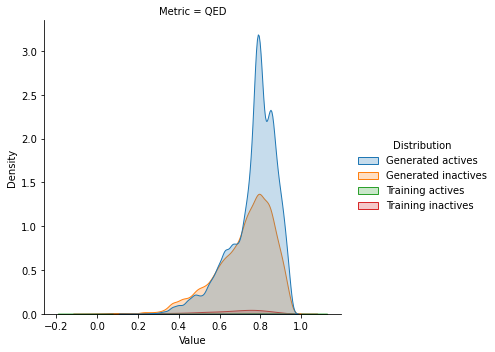

In [179]:
plot_distribution_basic(df_qed)

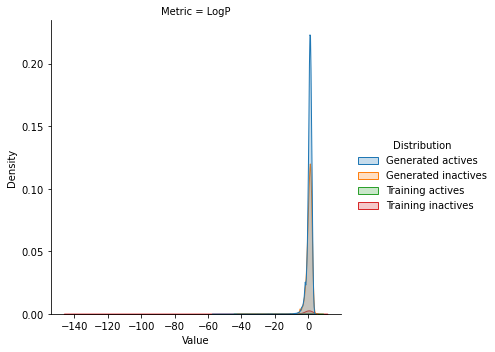

In [180]:
plot_distribution_basic(df_logp)

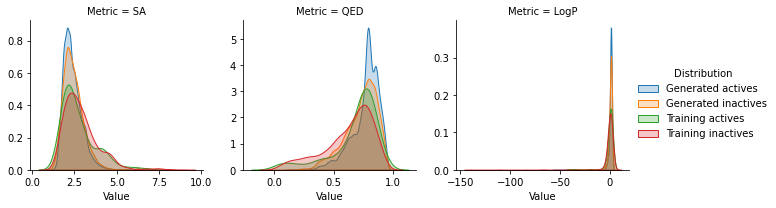

In [181]:
plot_distribution(df_metrics, save_path = "./aae_finetune_500k_metrics.pdf", save = True)

## End of document